## Cascade experiment
Idea:
Substitute first layer with cascade of convs.
Example
CONV1(5x5)-->Relu = CONV(3x3)-->CONV(3x3)-->Relu

### Get MNIST data
The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation).

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### MNIST training data
each sample on the MNIST dataset consist on a 784 feature vector encoding a 28x28 grayscale image. 

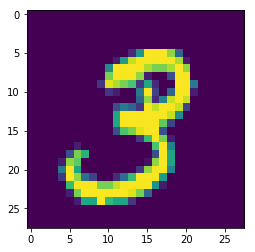

In [2]:
import matplotlib.pyplot as plt
imgDigit = mnist.train.images[1]
plt.imshow(imgDigit.reshape([28,28]))
plt.show()

### Importing libraries

In [3]:
import tensorflow as tf
import numpy as np

# Force to see just the first GPU
# https://devblogs.nvidia.com/parallelforall/cuda-pro-tip-control-gpu-visibility-cuda_visible_devices/
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Create functions for defining conv layers
One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

In [4]:
def conv2d_no_relu(x, k_h, k_w, channels_in, channels_out, name="conv"):
    with tf.name_scope(name):
        # Define weights
        w = tf.Variable(tf.truncated_normal([k_h,k_w, channels_in, channels_out], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        # Convolution
        conv = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')    
        
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", conv)
        return conv
    
def conv2d(x, k_h, k_w, channels_in, channels_out, name="conv"):
    with tf.name_scope(name):
        # Define weights
        w = tf.Variable(tf.truncated_normal([k_h,k_w, channels_in, channels_out], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        # Convolution
        conv = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')    
        # Relu
        activation = tf.nn.relu(conv + b)
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", activation)
        
        # Display trained weights as images on tensorboard
        # to tf.image_summary format [batch_size, height, width, channels]
        #w_t = tf.transpose (w, [3, 0, 1, 2])
        # this will display random 3 filters from the 64 in conv1
        #tf.summary.image(name+'/filters', w_t[:,:,:,0], max_outputs=3)        

        return activation

def max_pool(x, k_h, k_w, S, name="maxpool"):
    with tf.name_scope(name):
        return tf.nn.max_pool(x, ksize=[1, k_h, k_w, 1],strides=[1, S, S, 1], padding='SAME')

def fc_layer(x, channels_in, channels_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([channels_in, channels_out], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        activation = tf.nn.relu(tf.matmul(x, w) + b)
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", activation)
        return activation

### Creating our CNN model

#### Prepare input

In [5]:
# Create placeholders (I/O for our model/graph)
x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="y")

# Convert the feature vector to a (-1)x28x28x1 image
# The -1 has the same effect as the "None" value, and will
# be used to inform a variable batch size
x_image = tf.reshape(x, [-1,28,28,1])

#### Original network

In [ ]:
# Create network
conv1 = conv2d(x_image, 5, 5, 1, 16,"conv1")

pool1 = max_pool(conv1, 2, 2, 2, "pool1")
conv2 = conv2d(pool1, 3, 3, 16, 32, "conv2")
pool2 = max_pool(conv2, 2, 2, 2, "pool2")
# Needs calculation... (-1 means any batch size)
flattened = tf.reshape(pool2, [-1, 7*7*32])
fc1 = fc_layer(flattened, 7*7*32, 1024, "fc1")
# Add dropout to the fully connected layer
fc1_drop = tf.nn.dropout(fc1, 0.5)
scores = fc_layer(fc1_drop, 1024, 10, "fc2")

#### Cascading version no RELU in between

In [ ]:
# Create network
#conv1 = conv2d(x_image, 5, 5, 1, 16,"conv1") #25x16=400 Weights
# 9x32+9x16=432
conv1_1 = conv2d_no_relu(x_image, 3, 3, 1, 32,"conv1_1")
conv1_2 = conv2d(conv1_1, 3, 3, 32, 16,"conv1_2")

pool1 = max_pool(conv1_2, 2, 2, 2, "pool1")
conv2 = conv2d(pool1, 3, 3, 16, 32, "conv2")
pool2 = max_pool(conv2, 2, 2, 2, "pool2")
# Needs calculation... (-1 means any batch size)
flattened = tf.reshape(pool2, [-1, 7*7*32])
fc1 = fc_layer(flattened, 7*7*32, 1024, "fc1")
# Add dropout to the fully connected layer
fc1_drop = tf.nn.dropout(fc1, 0.5)
scores = fc_layer(fc1_drop, 1024, 10, "fc2")

#### Cascading version no RELU same filter-size

In [6]:
# Create network
#conv1 = conv2d(x_image, 5, 5, 1, 16,"conv1") #25x16=400 Weights
# 9x32+9x16=432
conv1_1 = conv2d_no_relu(x_image, 3, 3, 1, 16,"conv1_1")
conv1_2 = conv2d(conv1_1, 3, 3, 16, 16,"conv1_2")

pool1 = max_pool(conv1_2, 2, 2, 2, "pool1")
conv2 = conv2d(pool1, 3, 3, 16, 32, "conv2")
pool2 = max_pool(conv2, 2, 2, 2, "pool2")
# Needs calculation... (-1 means any batch size)
flattened = tf.reshape(pool2, [-1, 7*7*32])
fc1 = fc_layer(flattened, 7*7*32, 1024, "fc1")
# Add dropout to the fully connected layer
fc1_drop = tf.nn.dropout(fc1, 0.5)
scores = fc_layer(fc1_drop, 1024, 10, "fc2")

#### Cascading version with RELU in between

In [ ]:
# Create network
#conv1 = conv2d(x_image, 5, 5, 1, 16,"conv1") #25x16=400 Weights
# 9x32+9x16=432
conv1_1 = conv2d(x_image, 3, 3, 1, 32,"conv1_1")
conv1_2 = conv2d(conv1_1, 3, 3, 32, 16,"conv1_2")

pool1 = max_pool(conv1_2, 2, 2, 2, "pool1")
conv2 = conv2d(pool1, 3, 3, 16, 32, "conv2")
pool2 = max_pool(conv2, 2, 2, 2, "pool2")
# Needs calculation... (-1 means any batch size)
flattened = tf.reshape(pool2, [-1, 7*7*32])
fc1 = fc_layer(flattened, 7*7*32, 1024, "fc1")
# Add dropout to the fully connected layer
fc1_drop = tf.nn.dropout(fc1, 0.5)
scores = fc_layer(fc1_drop, 1024, 10, "fc2")

### Define a loss function and how to optimize it

In [7]:
# Multiclass cross-entropy
with tf.name_scope("cross_entropy"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores, labels=y))

# Solver configuration
with tf.name_scope("Solver"):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope("Accuracy"):
    correct_prediction = tf.equal(tf.argmax(scores,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add summary for cross_entropy loss, accuracy and the image
tf.summary.scalar("cross_entropy", cross_entropy)
tf.summary.scalar("accuracy", accuracy)
tf.summary.image("input", x_image, 3)

<tf.Tensor 'input:0' shape=() dtype=string>

### Build graph
Now we will initialize our variables, and create a session.

In [8]:
init = tf.global_variables_initializer()

# Avoid allocating the whole memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#sess = tf.Session()
sess.run(init)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("/tmp/mnist_demo/1")
writer.add_graph(sess.graph)


### Train graph (model/hypothesis)

In [9]:
for i in range(2000):
    # Get batch of 50 images
    batch = mnist.train.next_batch(50)
    
    # Dump summary
    if i % 5 == 0:
        s = sess.run(merged_summary, feed_dict={x:batch[0], y: batch[1]})
        writer.add_summary(s,i)    

    # Print accuracy
    # Print each 100 epochs
    if i%100 == 0:
        # Calculate train accuracy
        train_accuracy = accuracy.eval(session=sess, feed_dict={x:batch[0], y: batch[1]})
        print("step %d, training accuracy %g"%(i, train_accuracy))
                
    
    # Train actually here
    #train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

step 0, training accuracy 0.16
step 100, training accuracy 0.1
step 200, training accuracy 0.26
step 300, training accuracy 0.4
step 400, training accuracy 0.64
step 500, training accuracy 0.8
step 600, training accuracy 0.9
step 700, training accuracy 0.98
step 800, training accuracy 0.86
step 900, training accuracy 1
step 1000, training accuracy 0.94
step 1100, training accuracy 0.98
step 1200, training accuracy 0.94
step 1300, training accuracy 0.96
step 1400, training accuracy 0.98
step 1500, training accuracy 0.96
step 1600, training accuracy 0.98
step 1700, training accuracy 0.98
step 1800, training accuracy 0.9
step 1900, training accuracy 0.96


### Evaluating hypothesis
To display information on tensorboard use
```bash
tensorboard --logdir /tmp/mnist_demo/1
```

In [10]:
print("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})) 


Test Accuracy: 0.9608


### Conclusion
On the MNIST dataset the only thing that we can observe is that cascading layers make the convergence slower.
#### TODO:
Try on Resnet-18 with our dataset